In [1]:
import numpy as np
import pandas as pd
import json
from backtester import Backtest
from strategies.dataset import Dataset

In [2]:
with open('whale/result.json', 'r') as j:
    json_data = json.load(j).get('messages')
print(json_data[0].keys())

dict_keys(['id', 'type', 'date', 'actor', 'actor_id', 'action', 'title', 'text'])


In [3]:
def parse_int(txt):
    try:
        return float(''.join(i for i in txt if i.isdigit()))
    except Exception:
        return 0


def select_keys(data):
    return dict((k, data[k]) for k in ['date', 'text'] if k in data)

1
def preprocessing_text(data):
    temp = select_keys(data)
    if isinstance(temp, str):
        return False
    if temp.get('text') == 'whale-alert.io':
        return False

    date = temp.get('date')
    message = temp.get('text')
    link = ''
    text = []
    for i, v in enumerate(message):
        if isinstance(v, dict):
            if v.get('type') == 'hashtag':
                text.append(v.get('text'))
            elif v.get('type') == 'text_link':
                link = v.get('href')
        elif isinstance(v, str):
            text.append(v)

    text = "".join(text)
    if text.find('transferred') == -1:
        return False

    coin_value = parse_int(text.split(' ')[0])
    coin_usd = parse_int(text.split(' ')[2])
    ticker = text.split(' ')[1]
    transfer = text.split("from")[1].split("to")
    fromExh = transfer[0]
    toExh = transfer[1]

    df = dict({
        'time': date,
        'coin': ticker.lower(),
        'coin_value': coin_value,
        'coin_usd': coin_usd,
        'fromExh': fromExh.lower().replace(" ", "").strip(),
        'toExh': toExh.lower().replace(" ", "").strip(),
        'href': link

    })
    return df



In [4]:
data = [preprocessing_text(i) for i in json_data]
data = [i for i in data if i is not False]
data = pd.DataFrame.from_dict(data, orient='columns')
data = data.set_index('time')
data.index = pd.to_datetime(data.index)
data = data[(data['coin_value'] != 0) & data['coin_usd'] != 0]
data.loc[:, 'price'] = data['coin_usd'] / data['coin_value']
print(data.head(1).columns)

Index(['coin', 'coin_value', 'coin_usd', 'fromExh', 'toExh', 'href', 'price'], dtype='object')


## The largest transactions from the exchange

<AxesSubplot:title={'center':'From Exchange'}>

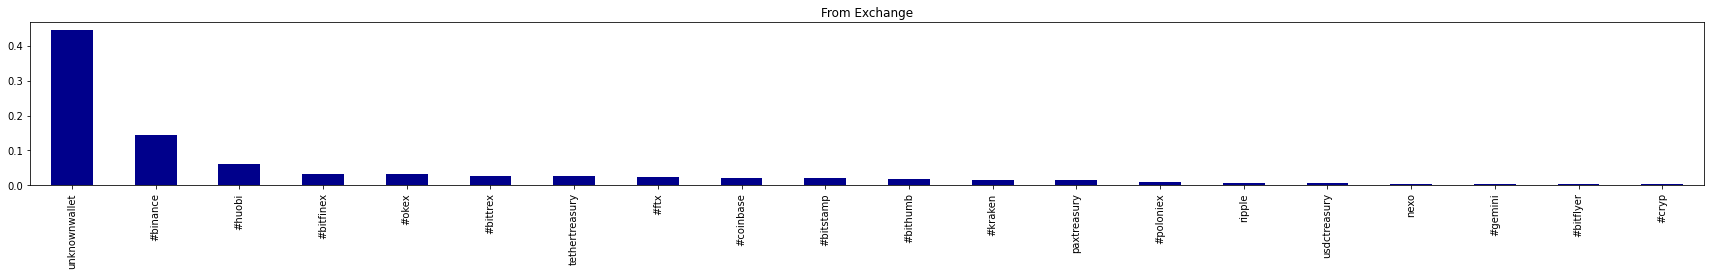

In [5]:
data['fromExh'].value_counts(normalize=True)[:20].plot.bar(figsize=(30, 3),color='darkblue', title='From Exchange')

<AxesSubplot:title={'center':'Coin'}>

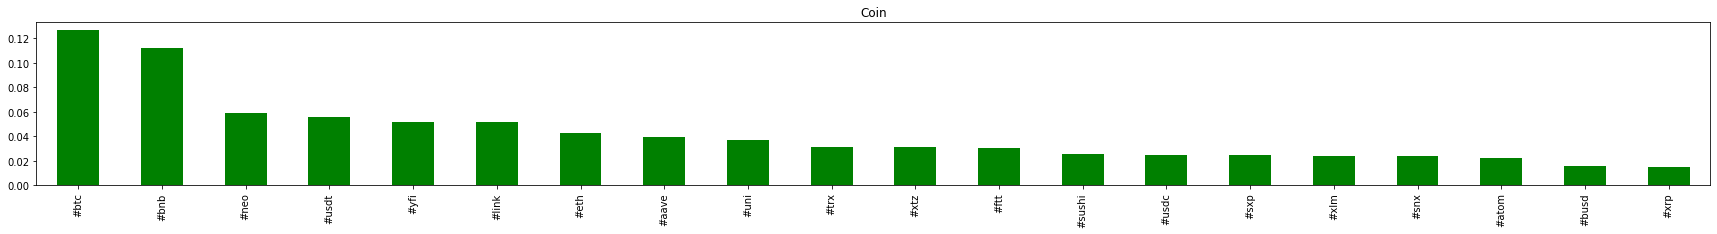

In [6]:
data[data['fromExh'] == '#binance']['coin'].value_counts(normalize=True)[:20].plot.bar(figsize=(30, 3),color='green', title='Coin')

## The largest transactions to the exchange

<AxesSubplot:title={'center':'To Exchange'}>

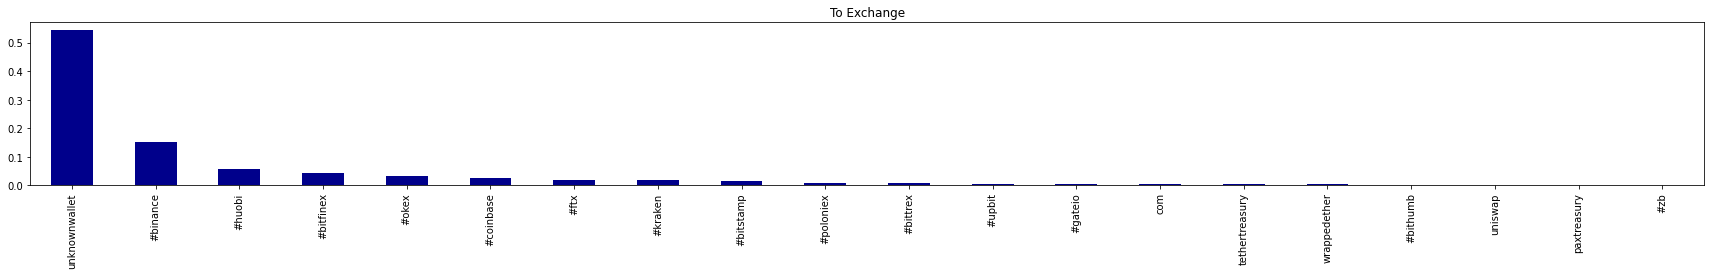

In [7]:
data['toExh'].value_counts(normalize=True)[:20].plot.bar(figsize=(30, 3),color='darkblue', title='To Exchange')

<AxesSubplot:title={'center':'Coin'}>

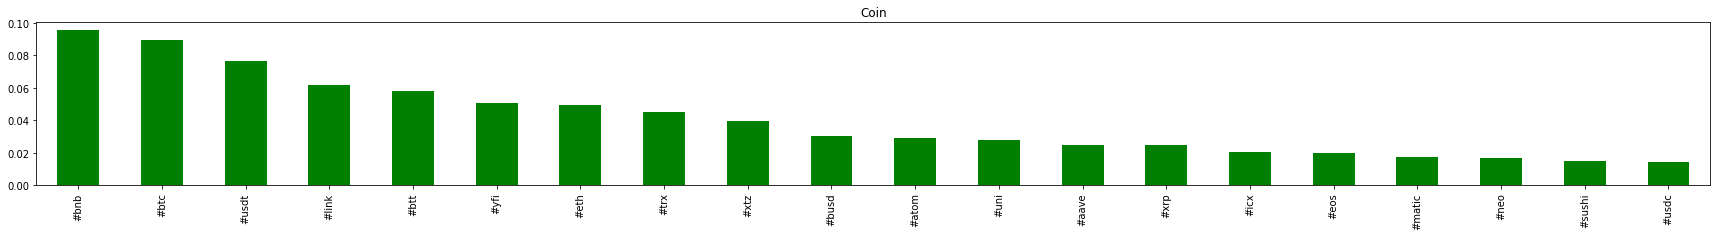

In [8]:
data[data['toExh'] == '#binance']['coin'].value_counts(normalize=True)[:20].plot.bar(figsize=(30, 3),color='green', title='Coin')

## The biggest transaction by each coin

                            coin   coin_usd        fromExh
coin  time                                                
#busd 2020-12-10 05:19:29  #busd  9999999.0    paxtreasury
#usdc 2020-08-21 22:51:56  #usdc  9999998.0   usdctreasury
#husd 2021-03-23 06:08:54  #husd  9999997.0       #binance
#usdt 2021-04-16 15:56:55  #usdt  9999960.0  unknownwallet
#btc  2019-08-09 12:57:42   #btc  9997938.0  unknownwallet
#xlm  2019-06-25 18:24:52   #xlm  9997291.0  unknownwallet
Average the biggest transaction of all coin $ USDT:  7248521.042372881


<AxesSubplot:xlabel='coin'>

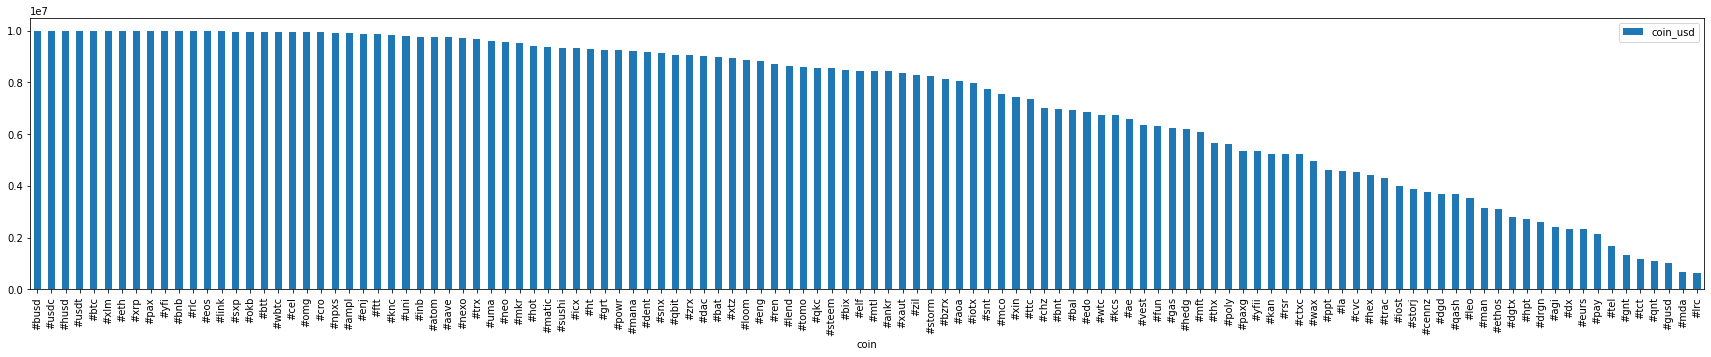

In [9]:
biggest_transaction = data.groupby('coin').apply(lambda x: x.nlargest(n=1, columns=['coin_usd'])).sort_values(by=['coin_usd'], ascending=False)
print(biggest_transaction[['coin', 'coin_usd', 'fromExh']].head(6))
print('Average the biggest transaction of all coin $ USDT: ' ,biggest_transaction['coin_usd'].mean())
biggest_transaction.plot.bar(figsize=(30, 5), x='coin', y='coin_usd')


## Analyse wallet


In [10]:
biggest_transaction[biggest_transaction['coin'] == '#btc']['href'].values[0]

'https://whale-alert.io/transaction/bitcoin/516844307449a564a2ae4a07fbaca1aeb0ad541de7817a9d836a1bb0d0ca06ef/1'

## How transactions affect bitcoin profitability

In [11]:
data_binance = Dataset()
price = data_binance.get_data(days=1800, ticker='BTCUSDT', ts='1H')

In [12]:
print(price.head(1))

                        open     high      low    close     volume
time                                                              
2017-08-17 05:00:00  4261.48  4313.62  4261.32  4308.83  47.181009


In [19]:
transaction_1H = data[['coin_value', 'coin_usd']].resample('1H').sum()
transaction_1H = transaction_1H.join(data['price'].resample('1H').mean(), on='time')
transaction_1H = transaction_1H.join(price, on='time')
print(transaction_1H.head(2))

                     coin_value    coin_usd        price     open     high  \
time                                                                         
2019-04-04 18:00:00    202424.0  13181716.0  3344.500974  4905.70  4945.00   
2019-04-04 19:00:00  49999979.0  44160262.0     2.878234  4871.39  4872.45   

                         low    close       volume  
time                                                
2019-04-04 18:00:00  4860.00  4869.24  3636.133826  
2019-04-04 19:00:00  4808.41  4844.25  5085.288799  


In [20]:
transaction_1H = transaction_1H.fillna(0)
transaction_1H.loc[:, 'y'] = transaction_1H['close'].shift(-1)
transaction_1H = transaction_1H.dropna()

## Price levels where the largest transactions take place


<AxesSubplot:xlabel='close', ylabel='coin_value'>

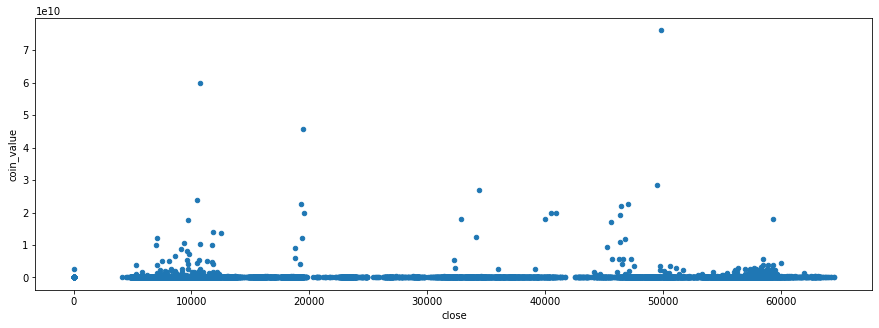

In [21]:
transaction_1H.plot.scatter(figsize=(15, 5), y='coin_value', x='close')

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [23]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
transaction_1H = clean_dataset(transaction_1H)
X_train, X_test, y_train, y_test = train_test_split(transaction_1H[['coin_usd', 'coin_value', 'price', 'close']], transaction_1H['y'], test_size=0.3, random_state=1)

In [24]:
model = RandomForestRegressor()
# cv = RepeatedKFold(n_splits=500, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [25]:
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00057
Feature: 1, Score: 0.00072
Feature: 2, Score: 0.00105
Feature: 3, Score: 0.99766


In [26]:
# output = pd.DataFrame({
#     'coin_usd': X_test['coin_usd'],
#     'close': X_test['close'],
#     'y': y_test,
#     'y_predict': y_predict,
#     'expected_return': (y_predict / y_test) -1
# }).sort_index()
# output = output[output['close'] != 0]
output = transaction_1H.tail(5000)
output.loc[:, 'y_predict'] = model.predict(output[['coin_usd', 'coin_value', 'price', 'close']])
output.loc[:, 'expected_return'] = (output['y_predict'] / output['y']) -1
output = output[output['close'] != 0]

/home/serg/CRYPTO/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/serg/CRYPTO/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:xlabel='y', ylabel='y_predict'>

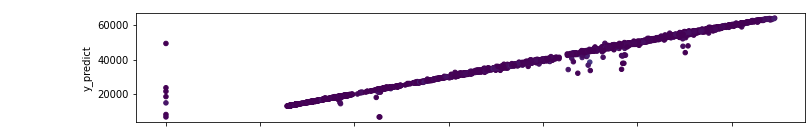

In [28]:
output.plot.scatter(x="y", y="y_predict", c='coin_usd', colormap='viridis', figsize=(15, 2))

In [30]:
output.loc[:, 'signal'] = np.where((output['y_predict'] > output['close']) & (output['expected_return'] > 0.003), -1, 0)
output.loc[:, 'signal'] = np.where((output['y_predict'] < output['close']) & (output['expected_return'] < -0.003), 1, output['signal'])
print(output['signal'].value_counts(normalize=True))

 0    0.788365
 1    0.115346
-1    0.096289
Name: signal, dtype: float64


<AxesSubplot:xlabel='time'>

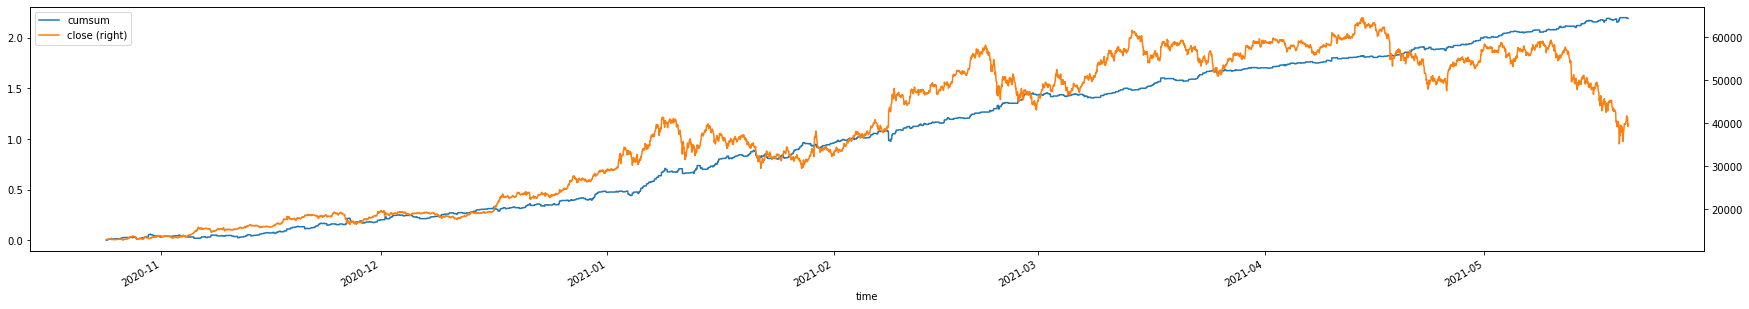

In [31]:
back = Backtest()
returns = back.exit_by_signal(data=output, take_profit=0.003, stop_loss=-0.003, comission=0.001)
returns[['cumsum', 'close']].plot(figsize=(30, 5), secondary_y=['close'])
# returns.plot.bar(figsize=(30, 5), y='coin_usd')

<AxesSubplot:xlabel='time'>

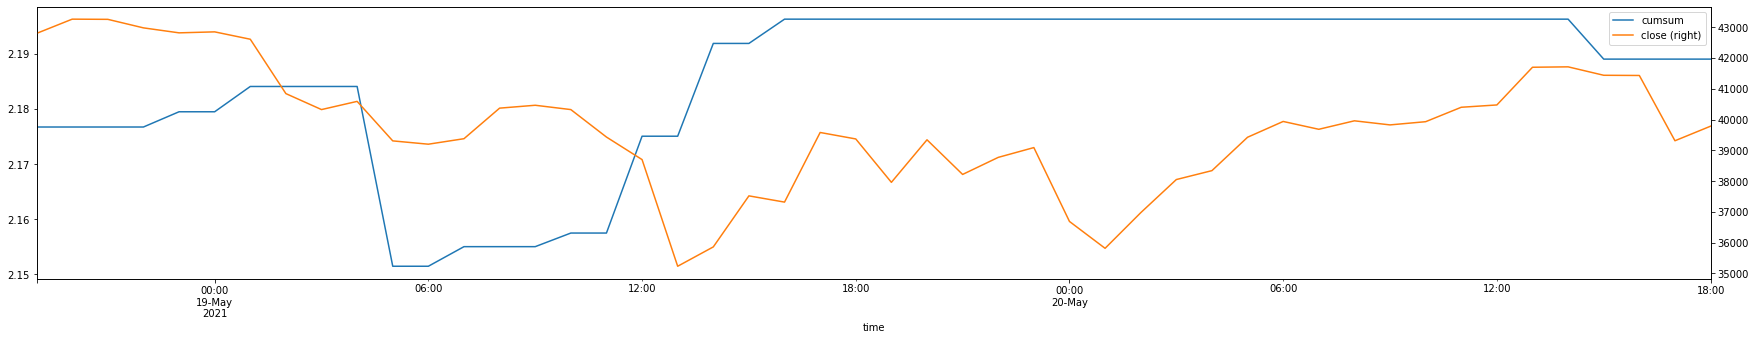

In [40]:
returns[['cumsum', 'close']].last('2D').plot(figsize=(30, 5), secondary_y=['close'])